In [14]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations, product

In [15]:
# name mapping dictionaries
names_wormhole_dict = {'hs':'human','mm':'mouse','ce':'worm',
                       'dm':'fly','dr':'zebrafish','sc':'yeast'}
names_MGI_dict = {'hs':'Homo_sapiens','mm':'Mus_musculus','ce':'Caenorhabditis_elegans',
                  'dm':'Drosophila_melanogaster','dr':'Danio_rerio','sc':'Saccharomyces_cerevisiae'}
names_IMP_dict = {'hs':'human','mm':'mouse','ce':'celegans',
                  'dm':'fly','dr':'zebrafish','sc':'yeast'}
# there are two of these because of yeast in gene2pub and STRING are a bit different
names_pubmed_dict = {'hs':9606,'mm':10090,'ce':6239,
                    'dm':7227,'dr':7955,'sc':559292}
names_STRING_dict = {'hs':9606,'mm':10090,'ce':6239,
                    'dm':7227,'dr':7955,'sc':4932}

# setup a dictionary of data
net_info = {"BioGRID":{},"IMP":{}}
for akey in net_info:
    for akey2 in list(names_MGI_dict):
        net_info[akey][akey2] = {}
        
# get the number of edges
fpedges1 = "../data/edgelists/single_species/BioGRID/"
FNs = glob.glob(fpedges1+"*.edgelist")
for aFN in FNs:
    for akey in list(names_MGI_dict):
        if names_MGI_dict[akey] in aFN:
            num_edges = sum(1 for line in open(aFN))
            net_info["BioGRID"][akey]["NumEdges"] = num_edges
fpedges2 = "../data/edgelists/single_species/IMP/"
FNs = glob.glob(fpedges2+"*.edgelist")
for aFN in FNs:
    for akey in list(names_IMP_dict):
        if names_IMP_dict[akey] in aFN:
            num_edges = sum(1 for line in open(aFN))
            net_info["IMP"][akey]["NumEdges"] = num_edges

# find the number of genes
for anet in ["BioGRID","IMP"]:
    fp = "../data/node_degrees/"
    df = pd.read_csv(fp+f"{anet}-Summed_Degrees.tsv",sep="\t")
    for akey in names_MGI_dict:
        num_genes = df[df["Specie"]==akey].shape[0]
        net_info[anet][akey]["NumGenes"] = num_genes
        # get the density
        full_edges = (num_genes*(num_genes-1))/2
        density = net_info[anet][akey]["NumEdges"] / full_edges
        net_info[anet][akey]["Density"] = density
        
def get_num_genes(sp1,sp2,anet):
    fp_ortho = "../data/edgelists/connections/"
    try:
        aFN = glob.glob(fp_ortho+f"{sp1}_{sp2}__{anet}*direct*AllOnes.edgelist")[0]
        df = pd.read_csv(aFN,header=None,sep="\t",names=["sp1","sp2","Weight"])
    except:
        try:
            aFN = glob.glob(fp_ortho+f"{sp2}_{sp1}__{anet}*direct*AllOnes.edgelist")[0]
            df = pd.read_csv(aFN,header=None,sep="\t",names=["sp2","sp1","Weight"])
        except:
            print("No file")
    num_genes = df["sp1"].nunique()
    return num_genes

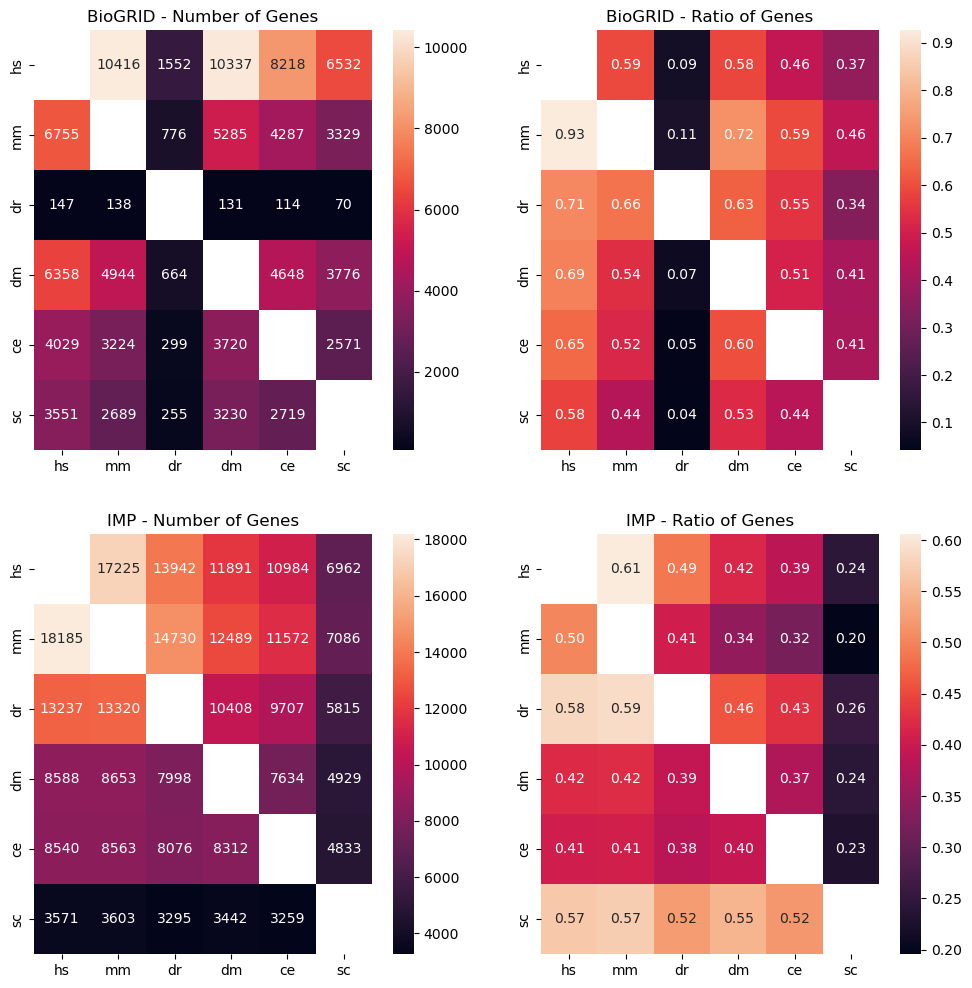

In [17]:
def make_ortho_plot():
    myspecies = ["hs","mm","dr","dm","ce","sc"]
    networks = ["BioGRID","IMP"]
    tasks = ["Number of Genes","Ratio of Genes"]
    ind_map = dict([(item,idx) for idx, item in enumerate(myspecies)])
    fig, ax = plt.subplots(2,2,figsize=(12,12))
    for ind2, anet in enumerate(networks):
        for ind1, atask in enumerate(tasks):
            num_genes = np.zeros((len(myspecies),len(myspecies)),dtype=float)
            mymask = np.zeros_like(num_genes)
            for acombo in product(myspecies,repeat=2):
                idx1 = ind_map[acombo[0]]
                idx2 = ind_map[acombo[1]]
                if acombo[0] == acombo[1]:
                    num_genes[idx1,idx2] = np.nan
                else:
                    if atask == "Number of Genes":
                        num_genes[idx1,idx2] = get_num_genes(acombo[0],acombo[1],anet)
                        myfmt = "0.0f"
                    elif atask == "Ratio of Genes":
                        num_genes[idx1,idx2] = get_num_genes(acombo[0],acombo[1],anet) / net_info[anet][acombo[0]]["NumGenes"]
                        myfmt = "0.2f"
            mymask[num_genes==0] = True
            sns.heatmap(num_genes,annot=num_genes,fmt=myfmt,
                        ax=ax[ind2,ind1],xticklabels=myspecies,yticklabels=myspecies)
            ax[ind2,ind1].set_title(f"{anet} - {atask}")
    fig.savefig("../figures/FigSM1.pdf")
make_ortho_plot()